In [1]:
# python
import os
import sys
import importlib
# columnar analysis
from coffea import processor
from coffea.nanoevents import NanoAODSchema
import awkward as ak
from dask.distributed import Client, performance_report
# local
sidm_path = str(os.getcwd()).split("/sidm")[0]
if sidm_path not in sys.path: sys.path.insert(1, sidm_path)
from sidm.tools import utilities, sidm_processor, scaleout, llpnanoaodschema
# always reload local modules to pick up changes during development
importlib.reload(utilities)
importlib.reload(sidm_processor)
importlib.reload(scaleout)
# plotting
import matplotlib.pyplot as plt
utilities.set_plot_style()
%matplotlib inline
from hist import intervals
import coffea.util
# import numpy as np
import mplhep as hep
import numpy as np
import warnings

In [2]:
import yaml
yaml_file_path = '../../configs/ntuples/signal_2mu2e_v10.yaml'
# Open and read the YAML file
with open(yaml_file_path, 'r') as file:
    data = yaml.safe_load(file)
signals_all = list(data["llpNanoAOD_v2"]["samples"].keys())
# for x in range(len(signals_all)):
#     # if x == 0:
#     print("'" + signals_all[x] + "',")
    

In [3]:
QCD=[ 
     "QCD_Pt15To20", 
     "QCD_Pt20To30",
     "QCD_Pt30To50",
     "QCD_Pt50To80",
     "QCD_Pt80To120",
     "QCD_Pt120To170",
    "QCD_Pt170To300",
    "QCD_Pt300To470",
     "QCD_Pt470To600",
     "QCD_Pt600To800",
    "QCD_Pt800To1000",
     "QCD_Pt1000",
    ]
DY = [ 
    "DYJetsToMuMu_M10to50",
    "DYJetsToMuMu_M50",
     ]
TT = [ 
    "TTJets",
     ]

bgs=  TT + QCD + DY


def sum_bgs_hist(bgs_list, histogram_name, channel_name):
    """
    Sum histograms for a list of backgrounds.
    """
    summed_hist = None
    
    for x in bgs_list:
        # print(x)
        output_bg = coffea.util.load(f"output_{x}{channel_name}.coffea")
        hist = output_bg["out"][x]["hists"][histogram_name][channel_name, :]
        
        if summed_hist is None:
            summed_hist = hist.copy()
        else:
            summed_hist += hist
    
    return summed_hist

def plot_signal_and_percentage_grid_all(data):
    # Collect all (bound_mass, zd_mass) pairs
    combos = []
    for mass, zd_dict in data.items():
        for zd in zd_dict.keys():
            combos.append((mass, zd))
    combos = sorted(combos, key=lambda x: (x[0], x[1]))  # sort nicely

    # Collect all Lxy values (y-axis)
    lab_vals = sorted(set(
        lab for mass in data for zd in data[mass] for lab in data[mass][zd].keys()
    ))
    # Initialize grids
    z_yield = np.full((len(lab_vals), len(combos)), np.nan)
    z_percent = np.full((len(lab_vals), len(combos)), np.nan)

    # Fill grids
    for j, (mass, zd) in enumerate(combos):
        for i, lab in enumerate(lab_vals):
            values = data[mass][zd].get(lab, [np.nan, np.nan])
            z_yield[i, j] = values[0]
            z_percent[i, j] = values[1]

    # X-axis labels like "100/0.25"
    x_labels = [f"{m}/{zd}" for m, zd in combos]


    fig, axs = plt.subplots(2, 1, figsize=(48, 30), constrained_layout=True)

    # --- Plot yield ---
    im1 = axs[0].imshow(
        z_yield,
        origin='lower',
        cmap='viridis',
        vmin=0, vmax=5,
        # norm=LogNorm(vmin=1e-2, vmax=1e2),
        aspect='auto'
    )
    axs[0].set_xticks(np.arange(len(combos)))
    axs[0].set_xticklabels(x_labels, rotation=90)
    axs[0].set_yticks(np.arange(len(lab_vals)))
    axs[0].set_yticklabels(lab_vals)
    axs[0].set_title(r"$S/\sqrt{B}$")
    axs[0].set_xlabel(r"Bound state / $m_{Z_d}$ (GeV)")
    axs[0].set_ylabel(r"$L_{xy}$ (cm)")
    plt.colorbar(im1, ax=axs[0])

    # --- Plot percentage ---
    im2 = axs[1].imshow(
        z_percent,
        origin='lower',
        cmap='viridis',
        vmin=0, vmax=0.05,
        aspect='auto'
    )
    axs[1].set_xticks(np.arange(len(combos)))
    axs[1].set_xticklabels(x_labels, rotation=90)
    axs[1].set_yticks(np.arange(len(lab_vals)))
    axs[1].set_yticklabels(lab_vals)
    axs[1].set_title("Threshold")
    axs[1].set_xlabel(r"Bound state / $m_{Z_d}$ (GeV)")
    axs[1].set_ylabel(r"$L_{xy}$ (cm)")
    plt.colorbar(im2, ax=axs[1])

    plt.show()
    plt.close()


In [4]:
channel_name = "base_ljObjCut_ljIso_2lj"
output_signal = coffea.util.load(f"output_signal{channel_name}.coffea" )
signals_per_plot = 15
n_signals = len(signals_all)
markers = ["o", "s", "^", "D", "v"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
thresholds = np.arange(0, 10, 1)
print("thresholds", thresholds)


thresholds [0 1 2 3 4 5 6 7 8 9]


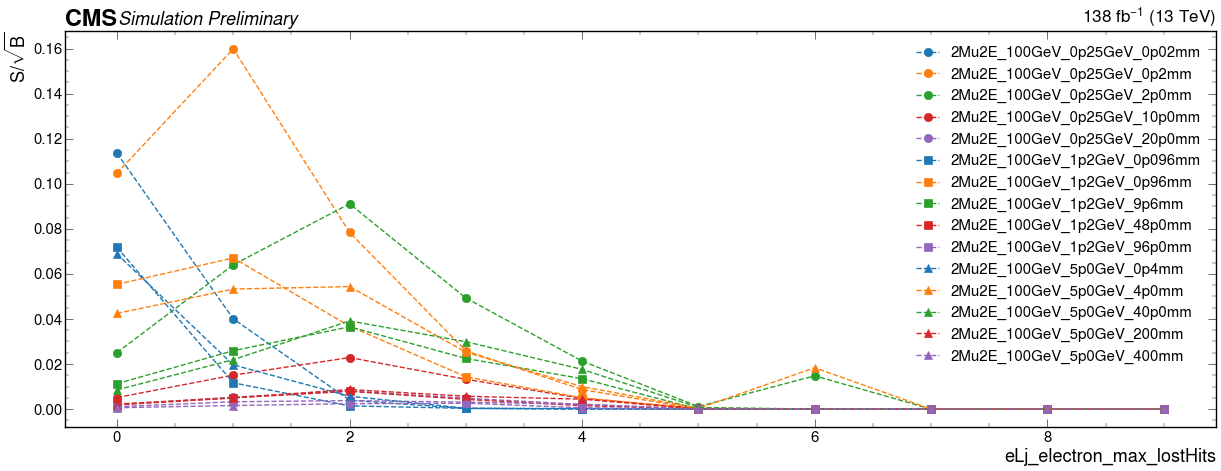

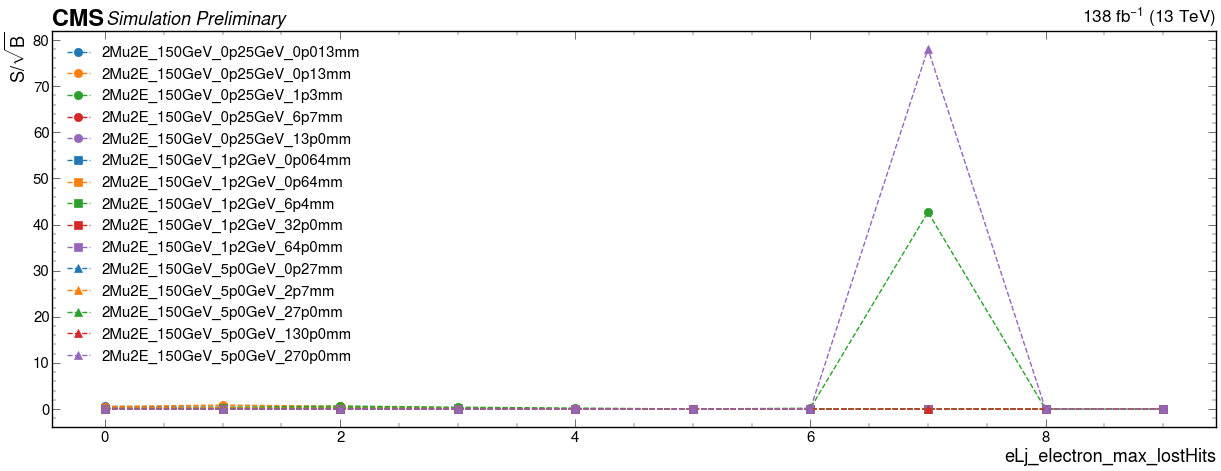

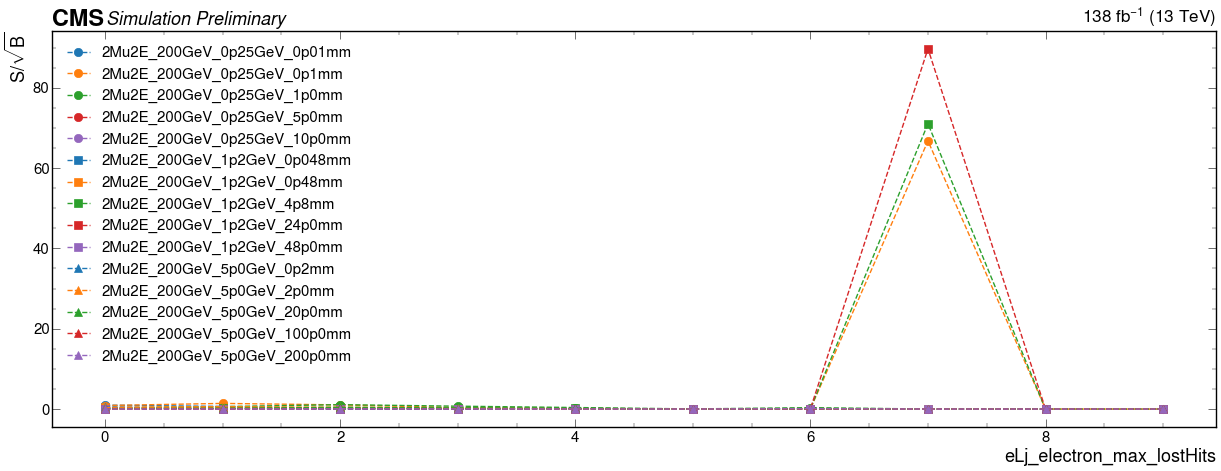

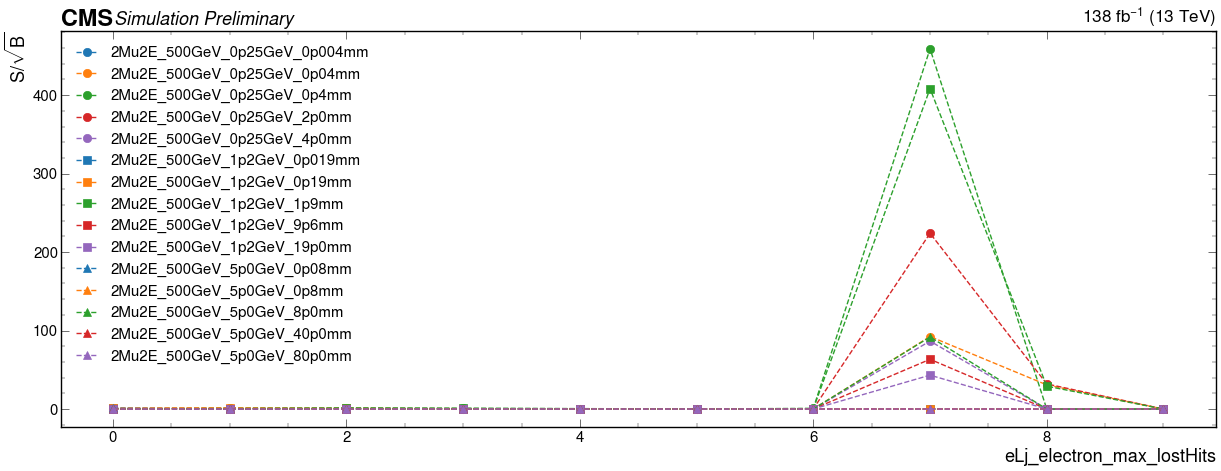

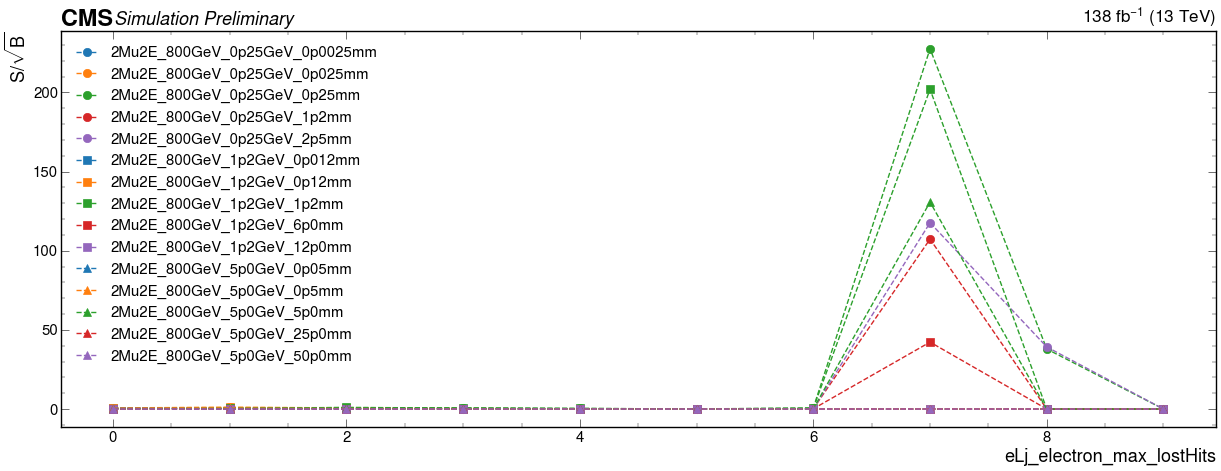

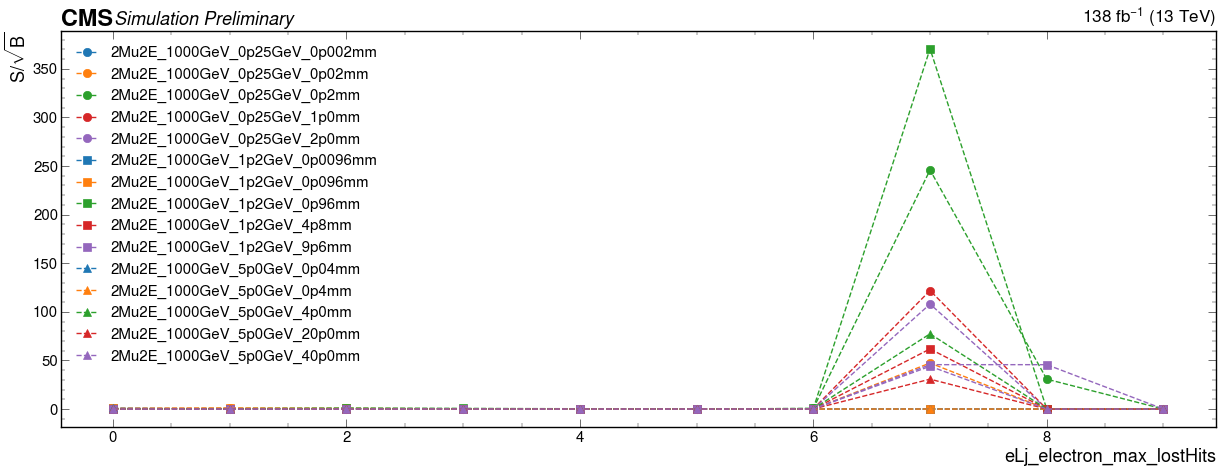

In [5]:
# === Parameters ===
histogram_name = "eLj_electron_max_lostHits"
markers = ["o", "s", "^", "D", "v"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
signals_per_plot = 15

# === Background ===
sum_bg = sum_bgs_hist(bgs, histogram_name, channel_name)
values_bg = sum_bg.values()
values_flow_bg = sum_bg.values(flow=True)
overflow_bg = values_flow_bg[-1]
underflow_bg = values_flow_bg[0]
bin_edges_bg = sum_bg.axes[0].edges

n_events_bg = []
for t in thresholds:
    idx = np.searchsorted(bin_edges_bg, t, side="right") - 1
    idx = max(idx, 0)
    n_events_bg_thres = values_bg[idx:].sum() + overflow_bg
    n_events_bg.append(n_events_bg_thres)

n_events_bg = np.array(n_events_bg)
# replace zeros to avoid division by zero
n_events_bg_safe = np.where(n_events_bg == 0, 1e-10, n_events_bg)

# print("Background events per threshold:", n_events_bg_safe)

# === Signals ===
n_signals = len(signals_all)

for i in range(0, n_signals, signals_per_plot):
    plt.figure(figsize=(25, 10))
    subset = signals_all[i:i + signals_per_plot]

    for j, s in enumerate(subset):
        # print("Processing:", s)
        # marker = markers[i // 5 % len(colors)] 

        histogram = output_signal["out"][s]["hists"][histogram_name][channel_name, :]
        values = histogram.values()
        values_flow = histogram.values(flow=True)
        overflow = values_flow[-1]
        underflow = values_flow[0]
        bin_edges = histogram.axes[0].edges

        n_events = []
        for threshold in thresholds:
            idx = np.searchsorted(bin_edges, threshold, side="right") - 1
            idx = max(idx, 0)
            n_events_thres = values[idx:].sum() + overflow
            n_events.append(n_events_thres)

        n_events = np.array(n_events)

        # === Compute S/√B safely ===
        s_over_rootB = n_events / np.sqrt(n_events_bg_safe)
        # replace inf or nan
        s_over_rootB = np.where(np.isfinite(s_over_rootB), s_over_rootB, np.nan)

        plt.plot(
            thresholds,
            s_over_rootB,
            marker=markers[j // 5 % len(colors)],
            linestyle="--",
            color=colors[j % len(colors)],
            markersize=12,
            linewidth=2,
            label=s
        )

    plt.xlabel(histogram_name)
    plt.ylabel(r"$S/\sqrt{B}$")
    plt.legend()
    hep.cms.label("Preliminary", data=False, lumi=138)
    plt.tight_layout()
    # plt.yscale("log")
    plt.show()
    plt.close()

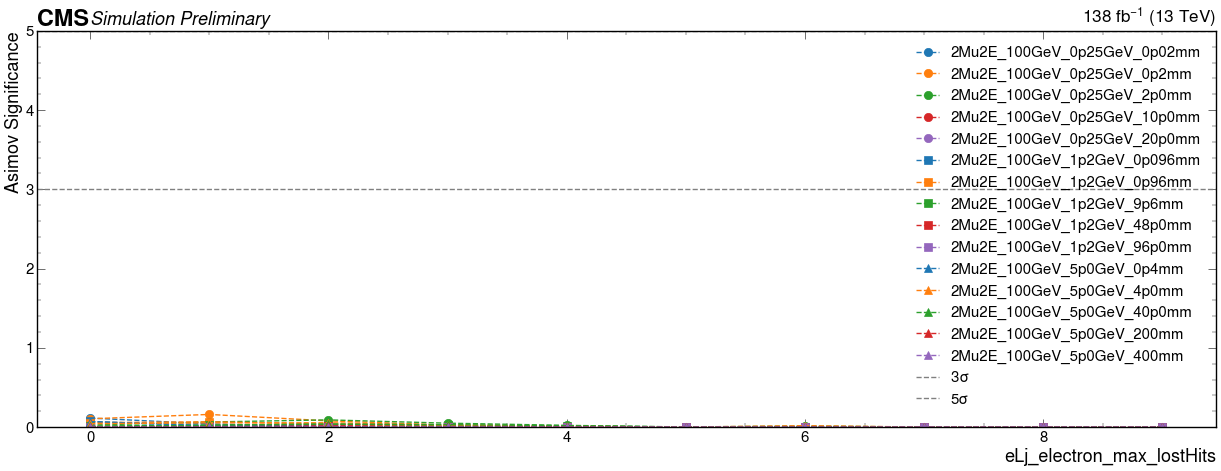

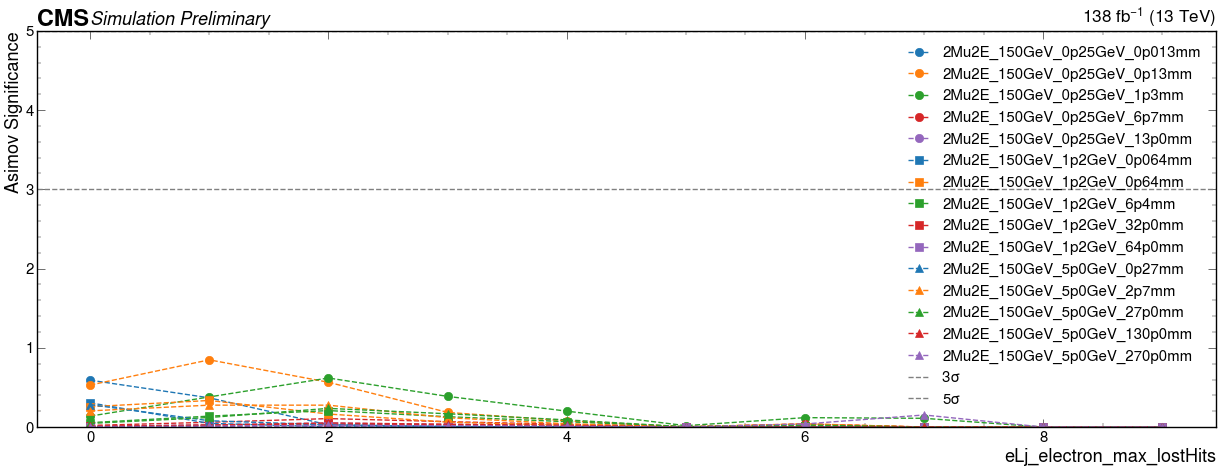

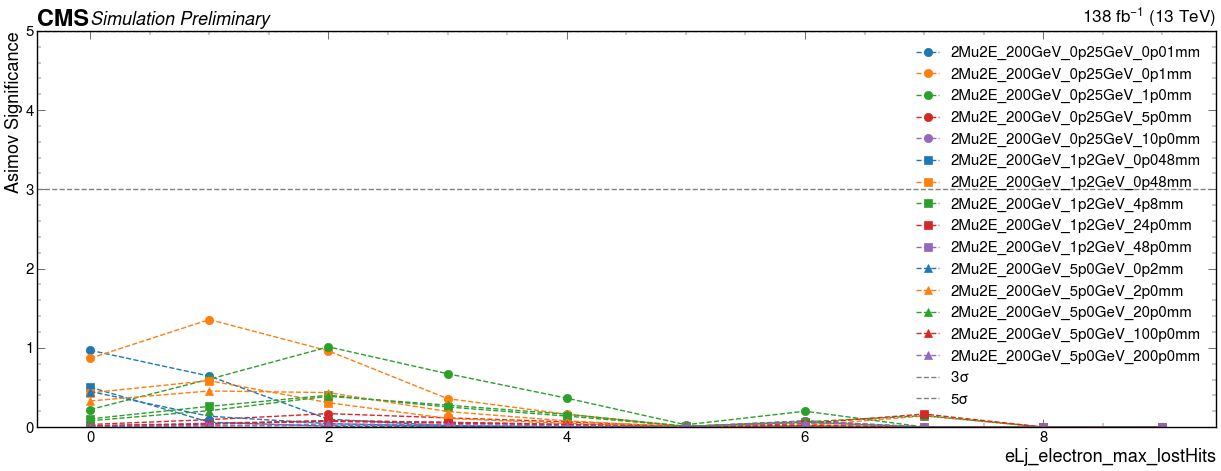

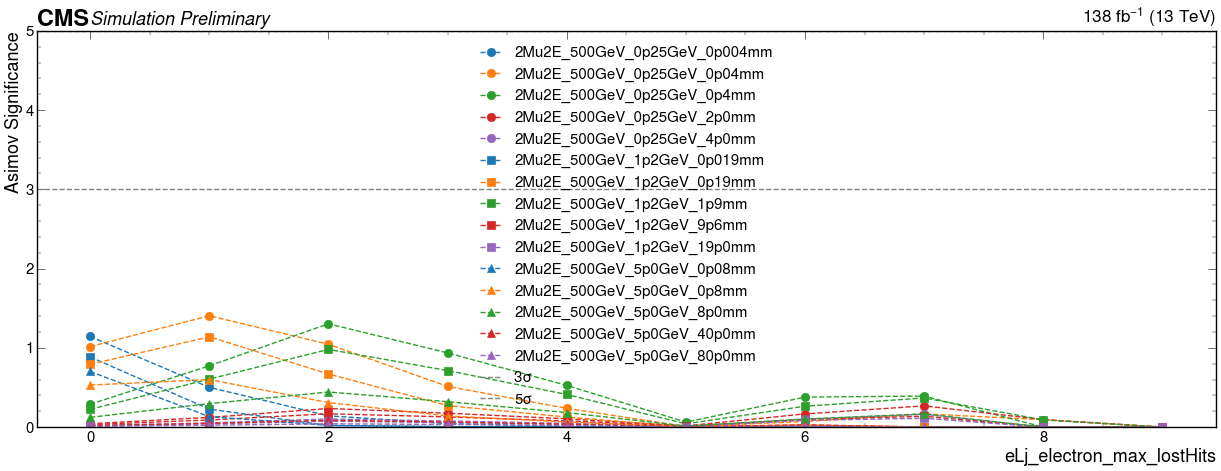

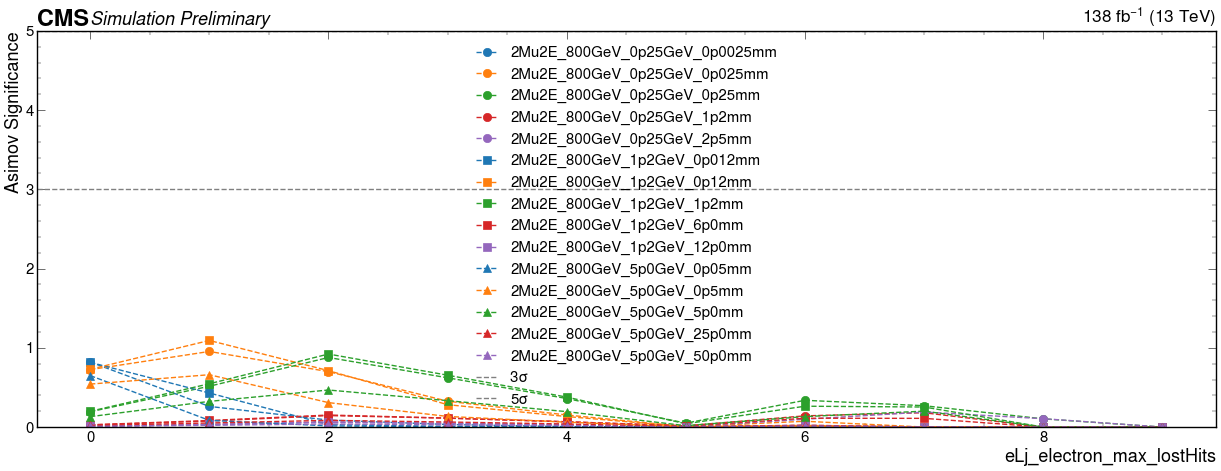

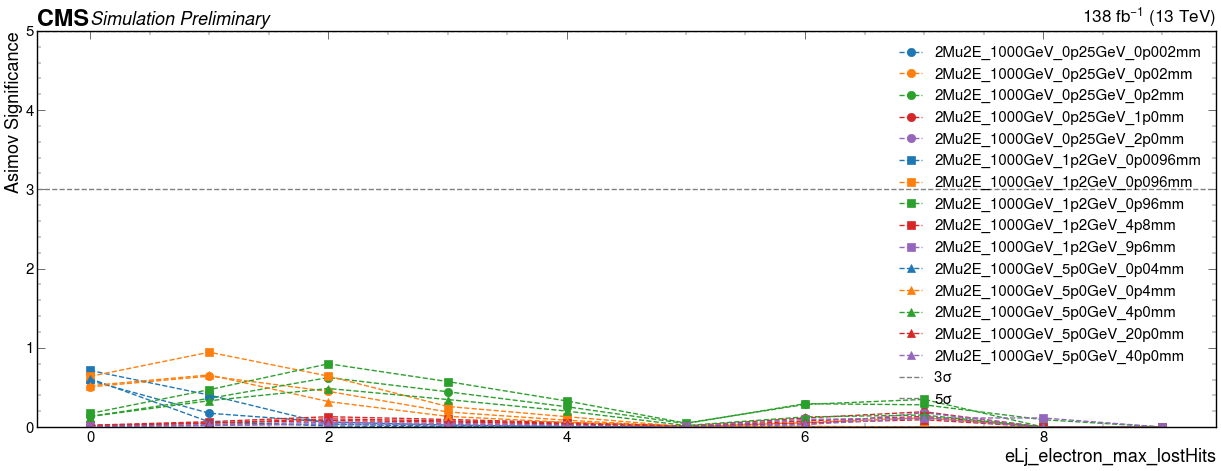

In [7]:
# === Parameters ===
histogram_name = "eLj_electron_max_lostHits"
markers = ["o", "s", "^", "D", "v"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
signals_per_plot = 15

# === Background ===
sum_bg = sum_bgs_hist(bgs, histogram_name, channel_name)
values_bg = sum_bg.values()
values_flow_bg = sum_bg.values(flow=True)
overflow_bg = values_flow_bg[-1]
underflow_bg = values_flow_bg[0]
bin_edges_bg = sum_bg.axes[0].edges

n_events_bg = []
for t in thresholds:
    idx = np.searchsorted(bin_edges_bg, t, side="right") - 1
    idx = max(idx, 0)
    n_events_bg_thres = values_bg[idx:].sum() + overflow_bg
    n_events_bg.append(n_events_bg_thres)

n_events_bg = np.array(n_events_bg)
# replace zeros to avoid division by zero
n_events_bg_safe = np.where(n_events_bg == 0, 1e-10, n_events_bg)

# print("Background events per threshold:", n_events_bg_safe)

# === Signals ===
# === Signals ===
n_signals = len(signals_all)

for i in range(0, n_signals, signals_per_plot):
    plt.figure(figsize=(25, 10))
    subset = signals_all[i:i + signals_per_plot]

    for j, S in enumerate(subset):

        histogram = output_signal["out"][S]["hists"][histogram_name][channel_name, :]
        values = histogram.values()
        values_flow = histogram.values(flow=True)
        overflow = values_flow[-1]
        underflow = values_flow[0]
        bin_edges = histogram.axes[0].edges

        n_events = []
        for threshold in thresholds:
            idx = np.searchsorted(bin_edges, threshold, side="right") - 1
            idx = max(idx, 0)
            n_events_thres = values[idx: ].sum() + overflow
            n_events.append(n_events_thres)

        n_events = np.array(n_events)

        # === Compute Asimov significance safely ===
        s = n_events
        b = n_events_bg
        # Avoid division by zero
        b_safe = np.where(b == 0, 1e-10, b)
        Z_Asimov = np.sqrt(2 * ((s + b_safe) * np.log(1 + s / b_safe) - s))
        Z_Asimov = np.where(np.isfinite(Z_Asimov), Z_Asimov, 0)

        plt.plot(
            thresholds,
            Z_Asimov,
            marker=markers[j // 5 % len(colors)],
            linestyle="--",
            color=colors[j % len(colors)],
            markersize=12,
            linewidth=2,
            label=S
        )
    plt.axhline(3, color='gray', linestyle='--', linewidth=2, label="3σ ")
    plt.axhline(5, color='grey', linestyle='--', linewidth=2, label="5σ")
    plt.xlabel(histogram_name)
    plt.ylim(0, 5)
    plt.ylabel("Asimov Significance")
    plt.legend()
    hep.cms.label("Preliminary", data=False, lumi=138)
    plt.tight_layout()
    plt.show()
    plt.close()